## Create, set up the environment, and install the packages 📦

```bash
python3.11 -m venv .venv
source .venv/bin/activate
pip install --upgrade pip
pip install scanpy spatools scvi-tools==1.2.0 ray pyarrow ipywidgets hyperopt scikit-misc
```

### From now on I will perform preprocessing in one public raw dataset: 
[10x Genomics Human Ovarian Cancer Dataset](https://www.10xgenomics.com/datasets/human-ovarian-cancer-11-mm-capture-area-ffpe-2-standard)
### Keep in mind that this first analysis are not automated, simply following the workflow from the multi-sample analysis (but with 1 sample) for better understanding of the preprocessing

## 1. Load data for viewing 1 spatial sample 

In [60]:
import os
import spatools as st

# read the 10x data
rd = st.read.Reading()
adata = rd.read_free(DIR = os.path.join(os.getcwd(), "data", "example_dataset"))

In [61]:
adata

AnnData object with n_obs × n_vars = 4674 × 18064
    obs: 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

### 1.1 exploratory analysis

In [62]:
adata.var.head(5) # returns the first 5 entries (genes) from the ‘var’ table

,gene_ids,feature_types,n_cells
SAMD11,ENSG00000187634,Gene Expression,3829
NOC2L,ENSG00000188976,Gene Expression,3915
KLHL17,ENSG00000187961,Gene Expression,2275
PLEKHN1,ENSG00000187583,Gene Expression,2185
PERM1,ENSG00000187642,Gene Expression,363


In [63]:
adata.obs.head(5)# returns the first 5 rows of the obs table, which contain metadata about the spots

,array_row,array_col
AACAATGTGCTCCGAG-1,98,158
AACACCATTCGCATAC-1,53,139
AACACGTTGATACCGC-1,85,87
AACACTCGTGAGCTTC-1,89,127
AACAGCCTCCTGACTA-1,104,118


### Comum error, adata.obsm["spatial"].values are str

In [64]:
adata.obsm["spatial"] #[x and y coordenates]

array([['4830', '29958'],
       ['8366', '15758'],
       ['17813', '25910'],
       ...,
       ['14069', '6626'],
       ['17816', '25279'],
       ['14343', '26212']], dtype=object)

In [65]:
adata.obsm["spatial"] = adata.obsm["spatial"].astype(int)

In [66]:
import squidpy as sq

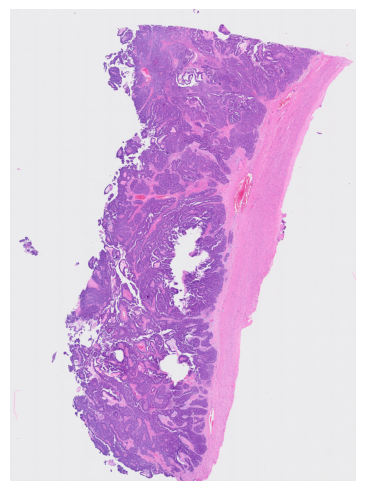

In [ ]:
sq.pl.spatial_scatter(adata)

#### 1.2 Preprocessing and quality control steps

In [68]:
import scanpy as sc

In [69]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [70]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [71]:
adata.var# new columns

,gene_ids,feature_types,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
SAMD11,ENSG00000187634,Gene Expression,3829,False,3829,6.628798,2.031930,18.078733,30983.0,10.341227
NOC2L,ENSG00000188976,Gene Expression,3915,False,3915,6.178434,1.971081,16.238768,28878.0,10.270870
KLHL17,ENSG00000187961,Gene Expression,2275,False,2275,0.774069,0.573276,51.326487,3618.0,8.193953
PLEKHN1,ENSG00000187583,Gene Expression,2185,False,2185,0.774283,0.573397,53.252033,3619.0,8.194229
PERM1,ENSG00000187642,Gene Expression,363,False,363,0.083226,0.079944,92.233633,389.0,5.966147
...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,4645,True,4645,61.346384,4.132706,0.620454,286733.0,12.566310
MT-ND4,ENSG00000198886,Gene Expression,4653,True,4653,120.326701,4.798487,0.449294,562407.0,13.239983
MT-ND5,ENSG00000198786,Gene Expression,4351,True,4351,13.697903,2.687705,6.910569,64024.0,11.067029
MT-ND6,ENSG00000198695,Gene Expression,4272,True,4272,7.560120,2.147114,8.600770,35336.0,10.472686


In [72]:
adata.var["mt"].value_counts() # number of mt genes


mt
False    18053
True        11
Name: count, dtype: int64

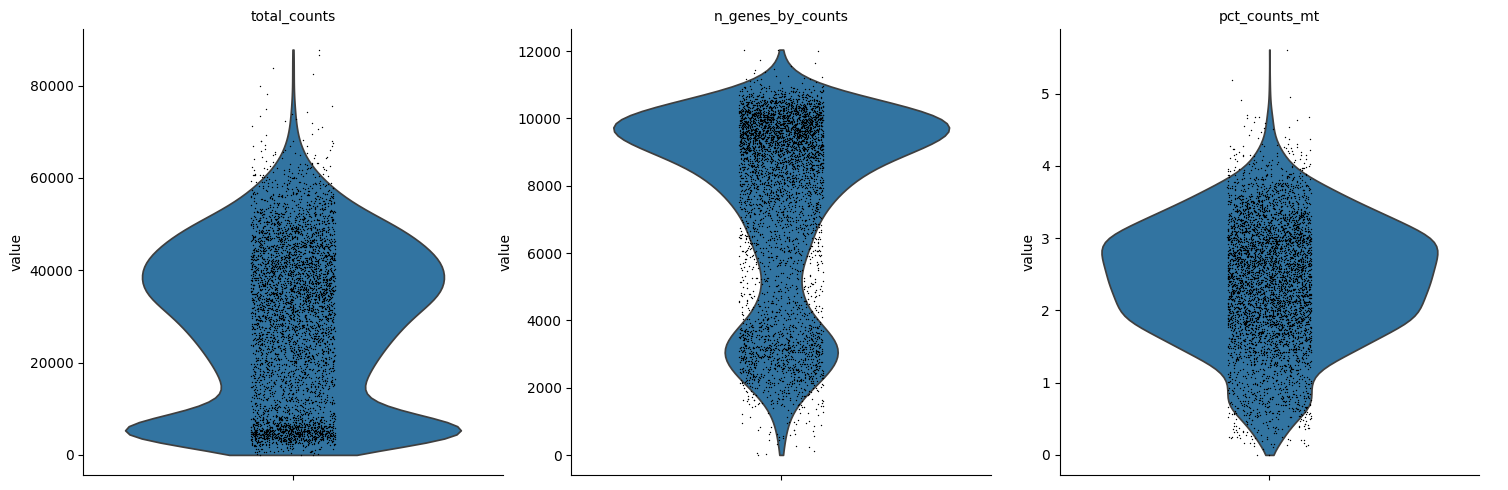

In [73]:
my_list = "total_counts", "n_genes_by_counts", "pct_counts_mt"
sc.pl.violin(adata, keys = my_list, multi_panel=True)

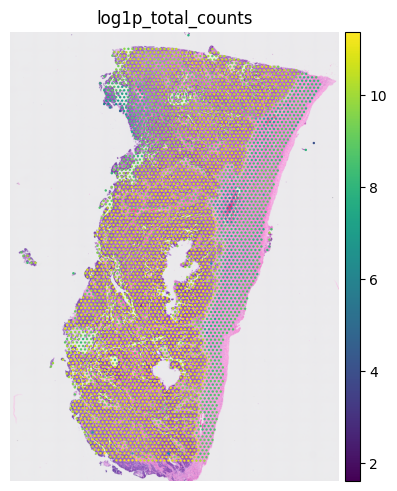

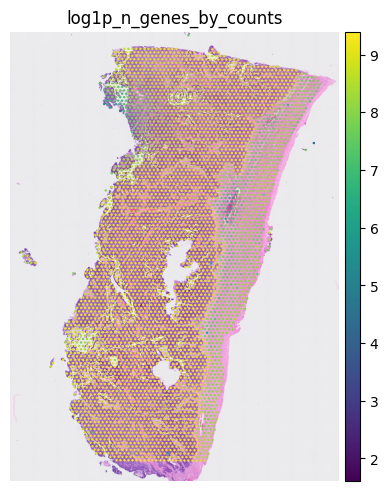

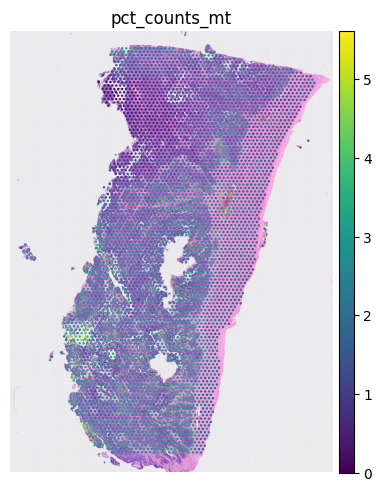

In [74]:
my_list = "log1p_total_counts", "log1p_n_genes_by_counts", "pct_counts_mt"
for _ in my_list:
    sq.pl.spatial_scatter(adata, color=_, frameon=False)

In [75]:
import numpy as np

In [76]:
def is_outlier(x, k=4, method='both'):
    """
    Identify outliers in an array of values using Median Absolute Deviation (MAD).

    Parameters
    ----------
    x : array-like
        Input array of values.
    k : int, optional
        The number of median absolute deviations from the median to consider a value
        an outlier. Default is 4.
    method : str, optional
        Method to identify outliers:
        - 'high': identify only high outliers (values above median + k*MAD)
        - 'low': identify only low outliers (values below median - k*MAD)  
        - 'both': identify both high and low outliers (default)

    Returns
    -------
    boolean array
        Boolean array indicating which values are outliers.

    Notes
    -----
    This function uses the Median Absolute Deviation (MAD) to identify outliers.
    The MAD is a robust measure of the spread of the data, and outliers are defined
    as values that are more than k times the MAD away from the median.
    
    Examples
    --------
    >>> data = [1, 2, 3, 4, 5, 100]  # 100 is a high outlier
    >>> is_outlier(data, method='high')
    array([False, False, False, False, False, True])
    
    >>> data = [-100, 2, 3, 4, 5, 6]  # -100 is a low outlier
    >>> is_outlier(data, method='low') 
    array([True, False, False, False, False, False])
    
    >>> data = [-100, 2, 3, 4, 5, 100]  # both -100 and 100 are outliers
    >>> is_outlier(data, method='both')
    array([True, False, False, False, False, True])
    """
    # Compute the median of the data
    median = np.median(x)
    
    # Compute the Median Absolute Deviation (MAD)
    mad = np.median(np.abs(x - median))
    
    # Compute the threshold values
    threshold = k * mad
    
    # Identify outliers based on the specified method
    if method == 'high':
        return (x - median) > threshold
    elif method == 'low':
        return (median - x) > threshold
    elif method == 'both':
        return np.abs(x - median) > threshold
    else:
        raise ValueError("Method must be 'high', 'low', or 'both'")

In [77]:
adata

AnnData object with n_obs × n_vars = 4674 × 18064
    obs: 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [88]:
import numpy as np
# genes and counts
def cut_spots(adata):
    adata = adata.copy()
    adata.obs['out_counts_low'] = is_outlier(adata.obs['log1p_total_counts'], method="low")
    adata.obs['out_genes'] = is_outlier(adata.obs['log1p_n_genes_by_counts'], method="low")
    adata.obs['out_combined'] = adata.obs['out_counts_low'] | adata.obs['out_genes']
    true_indexes = ~adata.obs['out_combined']
    adata = adata[true_indexes, :]

    # Remoção de genes mt
    adata = adata.copy()
    adata.obs["out_counts_mt"] = is_outlier(adata.obs["pct_counts_mt"], method = "high")
    true_indexes = adata.obs['out_counts_mt']
    true_indexes = true_indexes[~true_indexes].index
    adata = adata[true_indexes, :]

    return adata

adata = cut_spots(adata=adata)

In [89]:
adata

View of AnnData object with n_obs × n_vars = 3572 × 18064
    obs: 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'out_counts_low', 'out_genes', 'out_combined', 'out_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

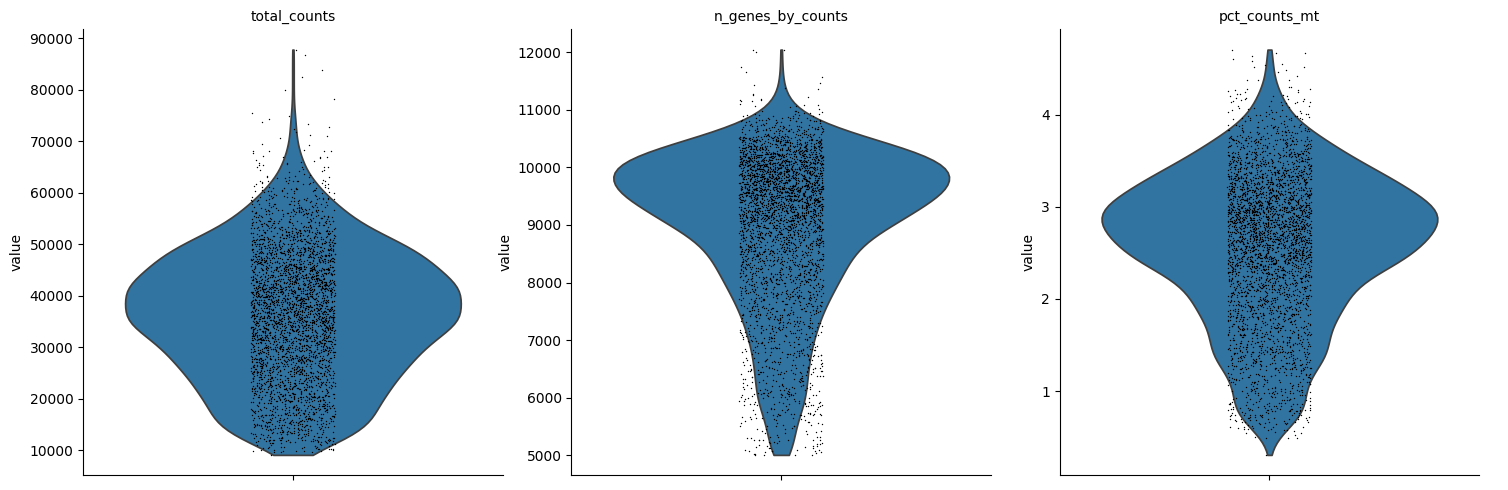

In [90]:
my_list = "total_counts", "n_genes_by_counts", "pct_counts_mt"
sc.pl.violin(adata, keys = my_list, multi_panel=True)

## Preprocessing for a dataset (>1 sample)

In [1]:
import os
import random
os.chdir("..")
from spatools.reading.read import Reading as rd
import scanpy as sc
import spatools as st
from copy import deepcopy

read = rd(dir_path=os.path.join(os.getcwd(), "data", "raw")) #

adatas_dir = read.list_dict_with_data_h5ad()
# print(adatas_dir)

adatas_dir_raw = deepcopy(adatas_dir)
# print(adatas_dir_raw)

Reading file: P10_PAR_S2.h5ad
Reading file: P11_PAR_S2.h5ad
Reading file: P12_POR_S2.h5ad
Reading file: P13_POR_S2.h5ad
Reading file: P14_POR_S2.h5ad
Reading file: P15_POR_S1.h5ad
Reading file: P16_POR_S1.h5ad
Reading file: P17_POR_S1.h5ad
Reading file: P18_POR_S1.h5ad
Reading file: P19_POR_S1.h5ad
Reading file: P1_GOR_S2.h5ad
Reading file: P2_GOR_S2.h5ad
Reading file: P3_GOR_S2.h5ad
Reading file: P4_GOR_S1.h5ad
Reading file: P5_GOR_S1.h5ad
Reading file: P6_GOR_S1.h5ad
Reading file: P7_GOR_S1.h5ad
Reading file: P8_GOR_S1.h5ad
Reading file: P9_GOR_S1.h5ad


In [ ]:
st.pp.preprocessar(adatas_dir=adatas_dir, save_files=True, genes_and_counts_outliers = True, mt_percentage_outliers=True, 
                    output_dir=os.path.join(os.getcwd(), "data", "filtered"))

In [ ]:
os.listdir(os.path.join(os.getcwd(), "data", "filtered"))

['P10_PAR_S2.h5ad',
 'P11_PAR_S2.h5ad',
 'P12_POR_S2.h5ad',
 'P13_POR_S2.h5ad',
 'P14_POR_S2.h5ad',
 'P15_POR_S1.h5ad',
 'P16_POR_S1.h5ad',
 'P17_POR_S1.h5ad',
 'P18_POR_S1.h5ad',
 'P19_POR_S1.h5ad',
 'P1_GOR_S2.h5ad',
 'P2_GOR_S2.h5ad',
 'P3_GOR_S2.h5ad',
 'P4_GOR_S1.h5ad',
 'P5_GOR_S1.h5ad',
 'P6_GOR_S1.h5ad',
 'P7_GOR_S1.h5ad',
 'P8_GOR_S1.h5ad',
 'P9_GOR_S1.h5ad']

In [8]:
# Check summary of data before and after preprocessing
spots_raw, genes_raw = st.pp.check_summary(dicionario=adatas_dir_raw)
print(f"Número de celulas antes {spots_raw}, numero de genes antes {genes_raw}")

spots, genes = st.pp.check_summary(dicionario=adatas_dir)
print(f"Número de celulas depois {spots}, numero de genes depois {genes}")
print(1-spots/spots_raw)

Número de celulas antes 24773, numero de genes antes 392217
Número de celulas depois 23563, numero de genes depois 390621
0.04884349897065354


## Before

/media/SATA/spatools/spatools/plotting/pl.py:658: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.var["gene_ids"].str.startswith("ENSG")[0] == True:
/media/SATA/spatools/spatools/plotting/pl.py:658: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.var["gene_ids"].str.startswith("ENSG")[0] == True:
/media/SATA/spatools/spatools/plotting/pl.py:658: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.var["gene_ids"].str

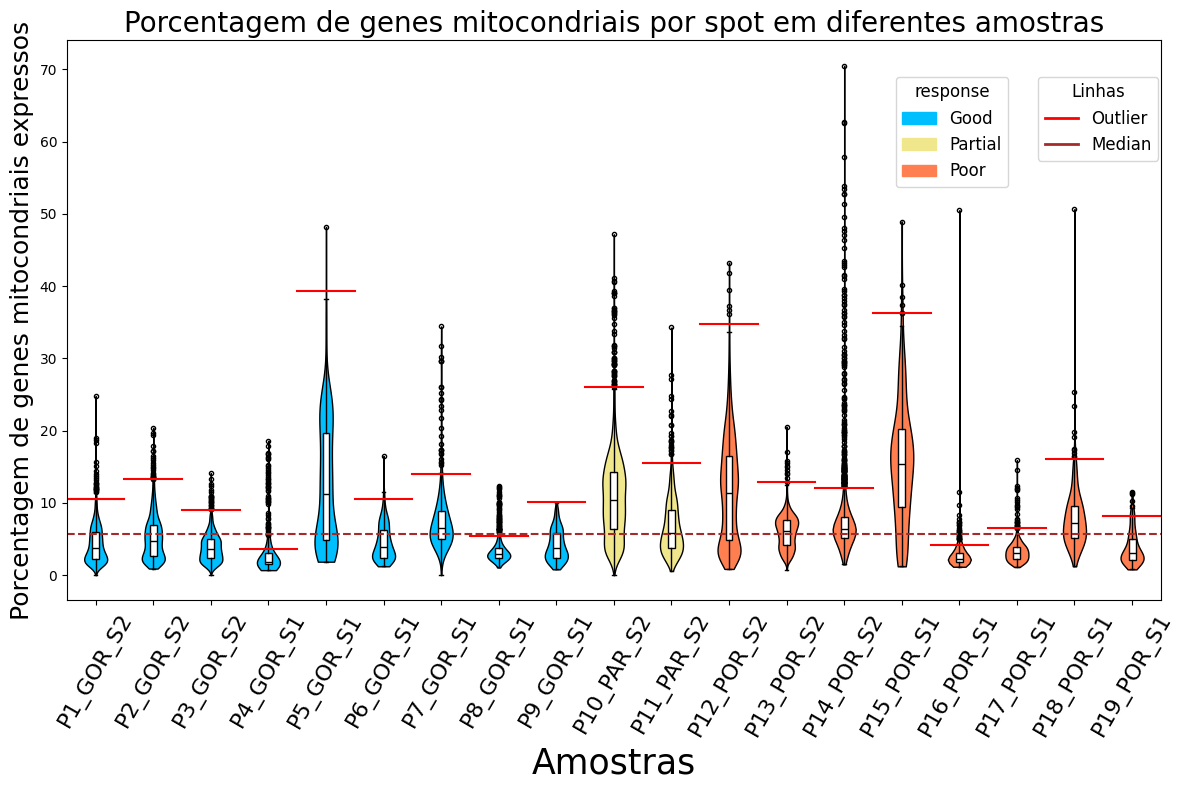

In [ ]:
classification_dict: dict[str, list[str]] = {
    "GOR": ["Good", "deepskyblue"],
    "PAR": ["Partial", "Khaki"],
    "POR": ["Poor", "coral"]
}

# calling the function outlier_quality

st.pl.outlier_quality(
    path_to_directory=os.path.join(os.getcwd(), "data", "raw"),
    clusters_col="pct_counts_mt",
    # clusters_col="log1p_n_genes_by_counts",
    # clusters_col= "log1p_total_counts",
    group_by="response",
    outlier_type="upper",# upper or lower
    outlier=4,
    add_line=True,
    add_outliers=True,
    # legend1_pos=(0.75, 0.25),
    # legend2_pos=(0.88, 0.25),
    title="Percentage of mitochondrial genes per spot in different samples",
    # title="Number of reads per spot in different samples",
    # title="Number of genes per spot in different samples",
    # ylabel="log1p of the number of reads",
    # ylabel="log1p of the number of genes",
    ylabel="Percentage of mitochondrial genes expressed",
    **classification_dict #type: ignore
)
# u can play around with the "#" TODO

## After

/media/SATA/spatools/spatools/plotting/pl.py:658: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.var["gene_ids"].str.startswith("ENSG")[0] == True:
/media/SATA/spatools/spatools/plotting/pl.py:658: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.var["gene_ids"].str.startswith("ENSG")[0] == True:
/media/SATA/spatools/spatools/plotting/pl.py:658: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.var["gene_ids"].str

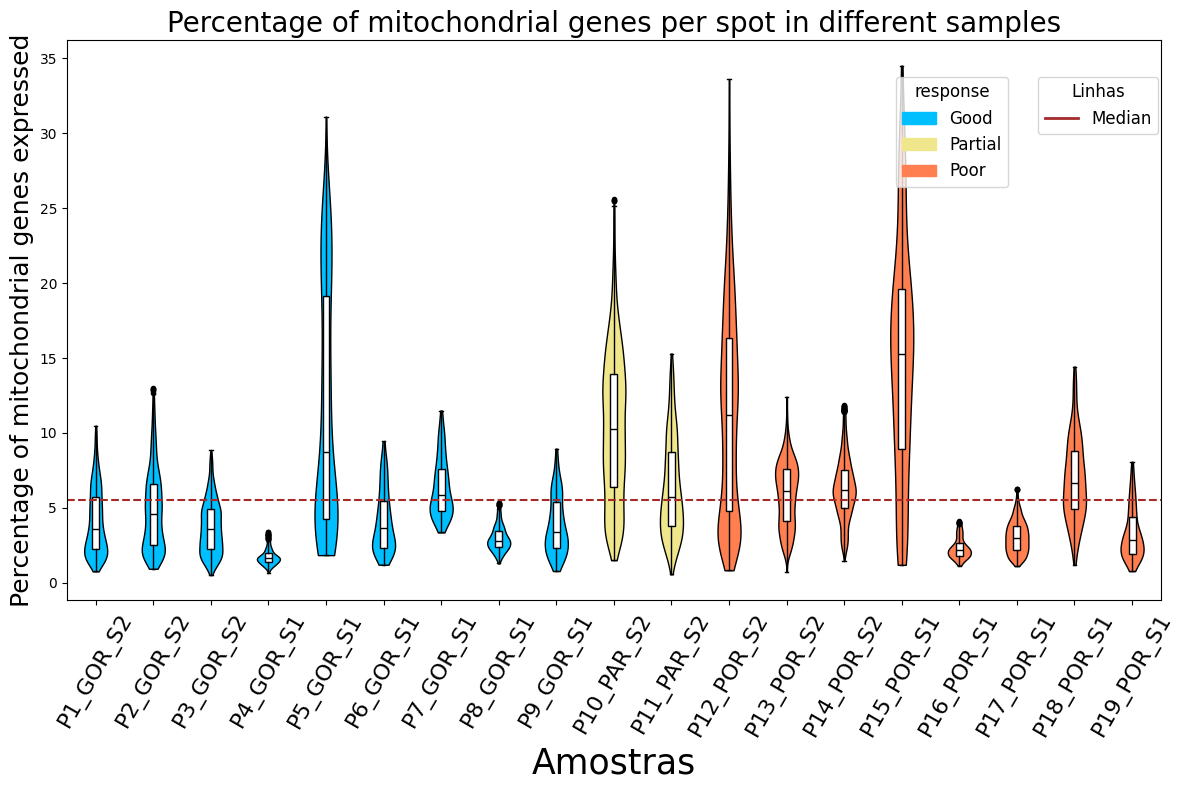

In [11]:
classification_dict: dict[str, list[str]] = {
    "GOR": ["Good", "deepskyblue"],
    "PAR": ["Partial", "Khaki"],
    "POR": ["Poor", "coral"]
}

# calling the function outlier_quality

st.pl.outlier_quality(
    path_to_directory=os.path.join(os.getcwd(), "data", "filtered"),
    clusters_col="pct_counts_mt",
    # clusters_col="log1p_n_genes_by_counts",
    # clusters_col= "log1p_total_counts",
    group_by="response",
    outlier=4,
    add_line=True,
    add_outliers=False,
    # legend1_pos=(0.75, 0.25),
    # legend2_pos=(0.88, 0.25),
    title="Percentage of mitochondrial genes per spot in different samples",
    # title="Number of reads per spot in different samples",
    # title="Number of genes per spot in different samples",
    # ylabel="log1p of the number of reads",
    # ylabel="log1p of the number of genes",
    ylabel="Percentage of mitochondrial genes expressed",
    **classification_dict #type: ignore
)
# u can play around with the "#" TODO